In [75]:
import torch
from torch import nn
from torchvision import models , transforms
import matplotlib.pyplot as plt

In [76]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [77]:
train_tansform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [78]:
test_tansform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [79]:
import torchvision
from torchvision.transforms import ToTensor, Resize, CenterCrop
def mask_transform(mask):
    mask = Resize((256, 256))(mask)
    mask = CenterCrop((256, 256))(mask)
    mask = ToTensor()(mask)
    return mask.squeeze(0).long()

traindataset = torchvision.datasets.OxfordIIITPet(

    root='./data', split='trainval', target_types='segmentation', download=True, transform=train_tansform, target_transform=mask_transform)

In [80]:
from torchvision.transforms import ToTensor
data = torchvision.datasets.OxfordIIITPet(root='./data', split='trainval', target_types='segmentation', download=True)

In [82]:
import torchvision
from torchvision.transforms import ToTensor, Resize, CenterCrop
def mask_transform(mask):
    mask = Resize((256, 256))(mask)
    mask = CenterCrop((256, 256))(mask)
    mask = ToTensor()(mask)
    return mask.squeeze(0).long()    

testdataset = torchvision.datasets.OxfordIIITPet(root='./data', split='test', target_types='segmentation', download=True, transform=test_tansform, target_transform=mask_transform)


In [94]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(traindataset, batch_size=16, shuffle=True, num_workers=0)
test_dataloader = DataLoader(testdataset, batch_size=16,shuffle=False, num_workers=0)

In [95]:
len(traindataset), len(testdataset)

(3680, 3669)

In [96]:
len(train_dataloader), len(test_dataloader) 

(230, 230)

In [ ]:
classes_names = traindataset.classes
classes_names[:10]

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair']

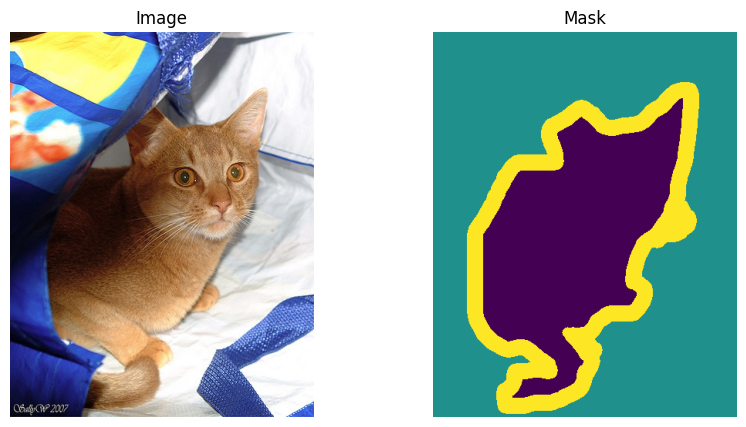

In [85]:
image, mask = data[0]
fig ,axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis('off')

axes[1].imshow(mask)
axes[1].set_title("Mask")   
axes[1].axis('off')
plt.show()

In [102]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', weights='DEFAULT', progress=True, )
model.classifier[4] = nn.Conv2d(256, 3, kernel_size=1)
model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred)
    return acc 

In [109]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.10, weight_decay=1e-4, nesterov=True)
loss_fn = nn.CrossEntropyLoss(ignore_index=2)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=1, power=0.01)

In [107]:
#create a training loop
def train_step(model :torch.nn.Module,
               dataloader : torch.utils.data.DataLoader,
               optimizer :torch.optim.Optimizer,
               loss_fn :torch.nn.Module,
               scheduler: torch.optim.lr_scheduler,
               accuracy_fn,
               device :torch.device):
    train_acc, train_loss  = 0, 0
    model.train()
    for batch, (X,Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        y_pred = model(X)
        if isinstance(y_pred, dict):
            y_pred = y_pred['out']
        loss = loss_fn(y_pred , Y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=Y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    print(f"Train loss : {train_loss:.4f} | Train acc : {train_acc:.4f}% |lr : {scheduler.get_last_lr()[0]:.4f}")

In [108]:
# create a testing loop
def test_step(model :torch.nn.Module,
              dataloader : torch.utils.data.DataLoader,
              loss_fn :torch.nn.Module,
              accuracy_fn, 
              device :torch.device):
    test_acc , test_loss = 0, 0
    model.eval()
    with torch.inference_mode():
       for batch , (X,Y) in enumerate(dataloader):
                X, Y = X.to(device), Y.to(device)
                y_pred = model(X)
                if isinstance(y_pred, dict):
                    y_pred = y_pred['out']
                loss = loss_fn(y_pred, Y)
                test_loss += loss.item()
                test_acc += accuracy_fn(y_true=Y, y_pred=y_pred.argmax(dim=1))
       test_loss = test_loss / len(dataloader)
       test_acc = test_acc / len(dataloader)       
       print(f"Test loss : {test_loss:.4f} | Test acc : {test_acc:.4f}%")        

In [ ]:
def print_train_time(start:float, end:float, device: torch.device):
    total_time = end - start
    print(f"\n train time on {device} : {total_time:.3f} seconds")
    return total_time

In [ ]:
from timeit import default_timer as timer 
from tqdm.auto import tqdm

start_time = timer()
epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch:{epoch+1}/{epochs}\n---")
    train_step(model=model,
               dataloader=train_dataloader,
               optimizer=optimizer,
               loss_fn=loss_fn,
               scheduler=scheduler,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model, 
              dataloader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device) 
    end_time = timer()
total_train_time = print_train_time(start=start_time, end=end_time, device=device)   

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:1/10
---


AttributeError: 'SGD' object has no attribute 'get_last_lr'